In [5]:
import pandas as pd
from pathlib import Path
from typing import Iterable, List

DATA_ROOT = Path(r"C:\Users\chris\Downloads\archive")

# Dow Jones tickers
DJIA_TICKERS = [
    "MMM", "AXP", "BA", "CAT",
    "CVX", "KO",  "XOM",
    "GS", "HD", "IBM", "JNJ",
    "JPM", "MCD", "MRK", "NKE",
    "PFE", "PG", "RTX", "TRV", "UNH",
    "VZ", "V", "WMT", "DIS",
]



def ticker_file_path(ticker: str, root: Path = DATA_ROOT) -> Path:
    """
    Find a file for the given ticker in the letter subfolder.
    Prefer .csv, but accept any extension.
    """
    first_letter = ticker[0].upper()
    folder = root / first_letter

    if not folder.exists():
        raise FileNotFoundError(f"Letter folder not found: {folder}")

    # Prefer exact CSV match: TICKER.csv
    csv_matches = list(folder.glob(f"{ticker}.csv"))
    if csv_matches:
        return csv_matches[0]

    # Otherwise, any TICKER.*
    any_matches = list(folder.glob(f"{ticker}.*"))
    if any_matches:
        return any_matches[0]

    # For debugging: show what IS in the folder
    files = [f.name for f in folder.iterdir()]
    raise FileNotFoundError(
        f"No file found for {ticker} in {folder}.\n"
        f"Files in folder: {files}"
    )


def load_single_ticker(
    ticker: str,
    root: Path = DATA_ROOT,
    parse_dates: bool = True,
) -> pd.DataFrame:
    """
    Load one ticker's OHLCV history and return a tidy DataFrame.

    Columns:
        timestamp (datetime)
        open, high, low, close, volume, ticker
    """
    path = ticker_file_path(ticker, root=root)
    suffix = path.suffix.lower()

    # Choose how to read based on file extension
    if suffix == ".csv":
        df = pd.read_csv(path)
    else:
        # Try as Excel; if that fails, fallback to CSV
        try:
            df = pd.read_excel(path, engine="openpyxl")
        except Exception:
            df = pd.read_csv(path)

    # Normalize column names
    df.columns = [c.strip().lower() for c in df.columns]

    expected = ["timestamp", "open", "high", "low", "close", "volume"]
    missing = [c for c in expected if c not in df.columns]
    if missing:
        raise ValueError(f"{ticker}: missing columns {missing} in {path}")

    df = df[expected]

    if parse_dates:
        df["timestamp"] = pd.to_datetime(df["timestamp"])

    df["ticker"] = ticker.upper()
    df = df.sort_values("timestamp").reset_index(drop=True)
    return df


# ========= Load many tickers (long format) =========

def load_universe(
    tickers: Iterable[str],
    root: Path = DATA_ROOT,
) -> pd.DataFrame:
    frames: List[pd.DataFrame] = []

    for ticker in tickers:
        try:
            df_t = load_single_ticker(ticker, root=root)
            frames.append(df_t)
        except FileNotFoundError as e:
            print(f"{e}")
        except Exception as e:
            print(f"Error loading {ticker}: {e}")

    if not frames:
        raise RuntimeError("No data loaded – check tickers or DATA_ROOT")

    data = pd.concat(frames, ignore_index=True)
    data = data.sort_values(["ticker", "timestamp"]).reset_index(drop=True)
    return data


def load_price_matrix(
    tickers: Iterable[str],
    root: Path = DATA_ROOT,
    price_col: str = "close",
) -> pd.DataFrame:
    data = load_universe(tickers, root=root)

    price_mat = (
        data.pivot(index="timestamp", columns="ticker", values=price_col)
            .sort_index()
    )
    return price_mat


# Test
dow_data = load_universe(DJIA_TICKERS)
#print(dow_data.head())
print("Tickers loaded:", sorted(dow_data["ticker"].unique()))

close_prices = load_price_matrix(DJIA_TICKERS)
#print(close_prices.head())
print("Shape:", close_prices.shape)


import numpy as np

UNIVERSE_TICKERS = sorted(dow_data["ticker"].unique())
print("Final universe tickers:", UNIVERSE_TICKERS)
print("Number of tickers:", len(UNIVERSE_TICKERS))



# ============================================
# Build OHLC matrices for this universe + log returns + OHLC tensor
# ============================================

def load_field(field: str) -> pd.DataFrame:
    """
    Load one OHLC field (open/high/low/close) for the universe and clean it.
    Returns a DataFrame of shape (T, N_ASSETS).
    """
    mat = load_price_matrix(DJIA_TICKERS, price_col=field)
    mat = mat[UNIVERSE_TICKERS].sort_index()
    mat = mat.ffill()  # forward-fill per column
    return mat

open_prices  = load_field("open")
high_prices  = load_field("high")
low_prices   = load_field("low")
close_prices = load_field("close")

# Make sure all 4 have exactly the same dates (intersection)
common_index = open_prices.index
common_index = common_index.intersection(high_prices.index)
common_index = common_index.intersection(low_prices.index)
common_index = common_index.intersection(close_prices.index)

open_prices  = open_prices.loc[common_index]
high_prices  = high_prices.loc[common_index]
low_prices   = low_prices.loc[common_index]
close_prices = close_prices.loc[common_index]

# Drop any remaining NaNs
open_prices  = open_prices.dropna()
high_prices  = high_prices.dropna()
low_prices   = low_prices.dropna()
close_prices = close_prices.dropna()

print("OHLC shapes:",
      open_prices.shape,
      high_prices.shape,
      low_prices.shape,
      close_prices.shape)

# ---- Log returns from close prices ----
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
print("Log returns shape:", log_returns.shape)

# ---- OHLC tensor aligned with log_returns ----
open_aligned  = open_prices.loc[log_returns.index]
high_aligned  = high_prices.loc[log_returns.index]
low_aligned   = low_prices.loc[log_returns.index]
close_aligned = close_prices.loc[log_returns.index]

# (T, N_ASSETS, 4) tensor: last dim = [open, high, low, close]
ohlc_all = np.stack(
    [open_aligned.values,
     high_aligned.values,
     low_aligned.values,
     close_aligned.values],
    axis=2,
)

print("OHLC tensor shape:", ohlc_all.shape)  # (T, N_ASSETS, 4)



# ============================================
# STEP 2: 60 / 20 / 20 time-based split
# ============================================

# Optionally restrict to data from 2008-10-01 onwards
log_returns = log_returns.loc["2008-10-01":].sort_index()

n = len(log_returns)
print("\nTotal observations after 2008-10-01:", n)
print("From:", log_returns.index.min(), "to:", log_returns.index.max())

# 60 / 20 / 20 split by time order
train_end_idx = int(0.6 * n)
val_end_idx   = int(0.8 * n)

train_returns = log_returns.iloc[:train_end_idx]
val_returns   = log_returns.iloc[train_end_idx:val_end_idx]
test_returns  = log_returns.iloc[val_end_idx:]

# Split OHLC tensor using the same indices
train_ohlc = ohlc_all[:train_end_idx]
val_ohlc   = ohlc_all[train_end_idx:val_end_idx]
test_ohlc  = ohlc_all[val_end_idx:]

print("\nShapes:")
print("Train OHLC shape:", train_ohlc.shape)
print("Val OHLC shape:", val_ohlc.shape)
print("Test OHLC shape:", test_ohlc.shape)

print("\nDate ranges:")
print("Train:", train_returns.index.min(), "→", train_returns.index.max())
print("Val  :", val_returns.index.min(), "→", val_returns.index.max())
print("Test :", test_returns.index.min(), "→", test_returns.index.max())



# ============================================
# STEP 3: RL-ready state representation (OHLC tensor + returns)
# State = last WINDOW_SIZE days of OHLC per asset
# ============================================

WINDOW_SIZE = 30

N_ASSETS = log_returns.shape[1]
print(f"Number of assets in universe: {N_ASSETS}")

def prepare_returns(returns_df: pd.DataFrame, window_size: int = WINDOW_SIZE):
    df = returns_df.dropna().sort_index()
    if len(df) <= window_size:
        raise ValueError(
            f"Not enough data ({len(df)}) for window size {window_size}"
        )
    return df.values, df.index  # (T, N_ASSETS), DatetimeIndex

# Returns arrays + date indices
train_arr, train_dates = prepare_returns(train_returns, WINDOW_SIZE)
val_arr,   val_dates   = prepare_returns(val_returns,   WINDOW_SIZE)
test_arr,  test_dates  = prepare_returns(test_returns,  WINDOW_SIZE)

print("Train returns array shape:", train_arr.shape)
print("Val returns array shape  :", val_arr.shape)
print("Test returns array shape :", test_arr.shape)

train_T = train_arr.shape[0]
val_T   = val_arr.shape[0]
test_T  = test_arr.shape[0]

train_ohlc_arr = train_ohlc[-train_T:]  # ensure same length as train_arr
val_ohlc_arr   = val_ohlc[-val_T:]
test_ohlc_arr  = test_ohlc[-test_T:]

print("Train OHLC array shape:", train_ohlc_arr.shape)  # (T, N_ASSETS, 4)

def get_state_ohlc(ohlc_arr: np.ndarray, t: int, window_size: int = WINDOW_SIZE):
    """
    Given OHLC array of shape (T, N_ASSETS, 4),
    return the state at time index t:
       state = last `window_size` days -> (window_size, N_ASSETS, 4)
    We require t >= window_size - 1.
    """
    if t < window_size - 1:
        raise ValueError(
            f"t must be >= window_size-1 (got t={t}, window_size={window_size})"
        )
    return ohlc_arr[t - window_size + 1 : t + 1]

def normalize_ohlc_window(state_np: np.ndarray) -> np.ndarray:
    """
    Normalize a window of OHLC data (WINDOW_SIZE, N_ASSETS, 4)
    by the last day's close per asset, similar in spirit to the paper.

    For each asset j:
      state[t, j, k] := state[t, j, k] / close_last_day(j)
    where close_last_day(j) = state[-1, j, 3].
    """
    state = np.asarray(state_np, dtype=np.float32).copy()  # (T, N, 4)
    # last day, close channel index 3
    last_close = state[-1, :, 3]  # shape (N_ASSETS,)
    # avoid division by zero
    last_close[last_close == 0] = 1.0
    # reshape for broadcasting: (1, N_ASSETS, 1)
    scale = last_close.reshape(1, -1, 1)
    state /= scale
    return state

# ---- Quick sanity check: get the first train state ----
t0 = WINDOW_SIZE - 1
state0 = get_state_ohlc(train_ohlc_arr, t0, WINDOW_SIZE)

print("\nExample OHLC state at t0:")
print("t0 index:", t0)
print("state0 shape:", state0.shape)  # (WINDOW_SIZE, N_ASSETS, 4)
print("state0[0, :3, :]:", state0[0, :3, :])  # first day, first 3 assets, all 4 fields

# ============================================
# STEP 4: PortfolioEnv (RL environment)
# ============================================
import numpy as np

class PortfolioEnv:
    """
    Simple portfolio RL environment.

    - Underlying data:
         returns_arr (T x N_ASSETS)
         ohlc_arr    (T x N_ASSETS x 4)
    - State: last WINDOW_SIZE days of OHLC -> (WINDOW_SIZE, N_ASSETS, 4)
    - Action: raw vector in R^N; mapped to weights via softmax
    - Reward: portfolio log return - transaction_cost * turnover
    """

    def __init__(
        self,
        returns_arr: np.ndarray,
        ohlc_arr: np.ndarray,
        dates: pd.DatetimeIndex,
        window_size: int = WINDOW_SIZE,
        episode_length: int = 252,
        transaction_cost: float = 0.001,
    ):
        assert returns_arr.ndim == 2, "returns_arr must be 2D (T x N_ASSETS)"
        assert ohlc_arr.ndim == 3, "ohlc_arr must be 3D (T x N_ASSETS x 4)"
        assert len(dates) == returns_arr.shape[0] == ohlc_arr.shape[0], \
            "dates, returns_arr, and ohlc_arr must have same T"
        assert returns_arr.shape[1] == ohlc_arr.shape[1], \
            "returns_arr and ohlc_arr must have same N_ASSETS"

        self.returns_arr = returns_arr
        self.ohlc_arr = ohlc_arr
        self.dates = dates
        self.window_size = window_size
        self.episode_length = episode_length
        self.transaction_cost = transaction_cost

        self.T, self.n_assets = returns_arr.shape

        # Internal state
        self.current_t = None
        self.step_count = None
        self.weights_prev = None
        self.portfolio_value = None

    # ---------- Utility functions ----------

    @staticmethod
    def _softmax(x: np.ndarray) -> np.ndarray:
        x = np.asarray(x, dtype=float)
        x = x - np.max(x)  # numerical stability
        e = np.exp(x)
        s = e.sum()
        if s <= 0:
            # fallback: equal-weight
            return np.ones_like(x) / len(x)
        return e / s

    def _get_state(self) -> np.ndarray:
        """
        Return current state:
        last `window_size` days of OHLC up to current_t
        shape = (window_size, n_assets, 4)
        """
        return get_state_ohlc(self.ohlc_arr, self.current_t, self.window_size)

    # ---------- RL API: reset & step ----------

    def reset(self, random_start: bool = True):
        """
        Reset the environment for a new episode.

        If random_start = True:
            pick a random starting index such that we have
            - enough history for the window
            - enough future steps for the episode
        """
        max_start_t = self.T - self.episode_length - 1
        min_t = self.window_size - 1

        if max_start_t <= min_t:
            raise ValueError(
                f"Not enough data T={self.T} for window_size={self.window_size} "
                f"and episode_length={self.episode_length}"
            )

        if random_start:
            self.current_t = np.random.randint(min_t, max_start_t + 1)
        else:
            self.current_t = min_t  # deterministic start

        self.step_count = 0
        self.portfolio_value = 1.0
        # Start from equal-weight portfolio
        self.weights_prev = np.ones(self.n_assets) / self.n_assets

        state = self._get_state()
        return state

    def step(self, action: np.ndarray):
        """
        Take one time step in the environment.

        Inputs:
            action: raw vector of size n_assets (can be any real numbers)

        Returns:
            next_state: (window_size, n_assets)
            reward: float
            done: bool
            info: dict (contains date, portfolio value, etc.)
        """
        action = np.asarray(action, dtype=float)
        if action.shape != (self.n_assets,):
            raise ValueError(
                f"Action shape must be ({self.n_assets},), got {action.shape}"
            )

        # Map raw action to valid portfolio weights via softmax
        weights_new = self._softmax(action)

        # Compute next time index
        t_next = self.current_t + 1

        # Asset log returns at t_next
        r_next = self.returns_arr[t_next]  # shape (n_assets,)

        # Portfolio log return (assuming we rebalance to weights_new at current_t)
        port_log_ret = float(np.dot(weights_new, r_next))

        # Transaction cost ~ L1 turnover
        turnover = np.abs(weights_new - self.weights_prev).sum()
        cost = self.transaction_cost * turnover

        # Reward = net portfolio log return
        reward = port_log_ret - cost

        # Update portfolio value (for monitoring)
        self.portfolio_value *= np.exp(reward)

        # Move time & counters
        self.current_t = t_next
        self.step_count += 1
        self.weights_prev = weights_new

        # Check if episode is done
        done = False
        if self.step_count >= self.episode_length:
            done = True
        if self.current_t >= self.T - 2:  # safety guard at end of data
            done = True

        # Next state
        next_state = self._get_state()

        info = {
            "date": self.dates[self.current_t],
            "portfolio_value": self.portfolio_value,
            "raw_log_return": port_log_ret,
            "transaction_cost": cost,
            "turnover": turnover,
        }

        return next_state, reward, done, info


Tickers loaded: ['AXP', 'BA', 'CAT', 'CVX', 'DIS', 'GS', 'HD', 'IBM', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'NKE', 'PFE', 'PG', 'RTX', 'TRV', 'UNH', 'V', 'VZ', 'WMT', 'XOM']
Shape: (16066, 24)
Final universe tickers: ['AXP', 'BA', 'CAT', 'CVX', 'DIS', 'GS', 'HD', 'IBM', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'NKE', 'PFE', 'PG', 'RTX', 'TRV', 'UNH', 'V', 'VZ', 'WMT', 'XOM']
Number of tickers: 24
OHLC shapes: (4434, 24) (4434, 24) (4434, 24) (4434, 24)
Log returns shape: (4433, 24)
OHLC tensor shape: (4433, 24, 4)

Total observations after 2008-10-01: 4298
From: 2008-10-01 00:00:00 to: 2025-10-30 00:00:00

Shapes:
Train OHLC shape: (2578, 24, 4)
Val OHLC shape: (860, 24, 4)
Test OHLC shape: (995, 24, 4)

Date ranges:
Train: 2008-10-01 00:00:00 → 2018-12-27 00:00:00
Val  : 2018-12-28 00:00:00 → 2022-05-26 00:00:00
Test : 2022-05-27 00:00:00 → 2025-10-30 00:00:00
Number of assets in universe: 24
Train returns array shape: (2578, 24)
Val returns array shape  : (860, 24)
Test returns ar

In [6]:

    
# ============================================
# Sanity test for PortfolioEnv
# ============================================

env = PortfolioEnv(
    returns_arr=train_arr,
    ohlc_arr=train_ohlc_arr,
    dates=train_dates,
    window_size=WINDOW_SIZE,
    episode_length=252,
    transaction_cost=0.001,
)

state = env.reset(random_start=True)
print("Initial state shape:", state.shape)

done = False
total_reward = 0.0

for step in range(10):  # just 10 random steps for testing
    # Random action: normal noise
    action = np.random.randn(env.n_assets)
    next_state, reward, done, info = env.step(action)
    total_reward += reward

    print(
        f"Step {step:2d} | "
        f"Date: {info['date'].date()} | "
        f"Reward: {reward: .6f} | "
        f"PV: {info['portfolio_value']:.4f}"
    )

    if done:
        print("Episode finished early at step", step)
        break

print("Total reward over 10 steps:", total_reward)

Initial state shape: (30, 24, 4)
Step  0 | Date: 2017-06-08 | Reward: -0.001526 | PV: 0.9985
Step  1 | Date: 2017-06-09 | Reward:  0.008352 | PV: 1.0068
Step  2 | Date: 2017-06-12 | Reward: -0.000124 | PV: 1.0067
Step  3 | Date: 2017-06-13 | Reward:  0.001648 | PV: 1.0084
Step  4 | Date: 2017-06-14 | Reward:  0.002311 | PV: 1.0107
Step  5 | Date: 2017-06-15 | Reward: -0.000094 | PV: 1.0106
Step  6 | Date: 2017-06-16 | Reward: -0.001235 | PV: 1.0094
Step  7 | Date: 2017-06-19 | Reward:  0.002092 | PV: 1.0115
Step  8 | Date: 2017-06-20 | Reward: -0.001142 | PV: 1.0103
Step  9 | Date: 2017-06-21 | Reward: -0.004698 | PV: 1.0056
Total reward over 10 steps: 0.0055827249765172905


#  1. Baseline: A2C (flatten OHLC + MLP)

Matplotlib is building the font cache; this may take a moment.


Using device: cpu
state_dim: 2880 | action_dim: 24
Episode   10 | Steps: 252 | Total reward: -0.1764 | Actor loss:  0.4601 | Critic loss:  0.0006
Episode   20 | Steps: 252 | Total reward: -0.2012 | Actor loss: -0.2110 | Critic loss:  0.0019
Episode   30 | Steps: 252 | Total reward: -0.1649 | Actor loss: -0.0549 | Critic loss:  0.0034
Episode   40 | Steps: 252 | Total reward: -0.3079 | Actor loss: -0.3049 | Critic loss:  0.0095
Episode   50 | Steps: 252 | Total reward: -0.1512 | Actor loss: -0.1979 | Critic loss:  0.0017
Episode   60 | Steps: 252 | Total reward: -0.0966 | Actor loss:  0.0171 | Critic loss:  0.0040
Episode   70 | Steps: 252 | Total reward: -0.1372 | Actor loss:  0.1695 | Critic loss:  0.0032
Episode   80 | Steps: 252 | Total reward: -0.0911 | Actor loss:  0.1574 | Critic loss:  0.0010
Episode   90 | Steps: 252 | Total reward: -0.2200 | Actor loss: -0.0335 | Critic loss:  0.0031
Episode  100 | Steps: 252 | Total reward: -0.1768 | Actor loss: -0.0242 | Critic loss:  0.0014

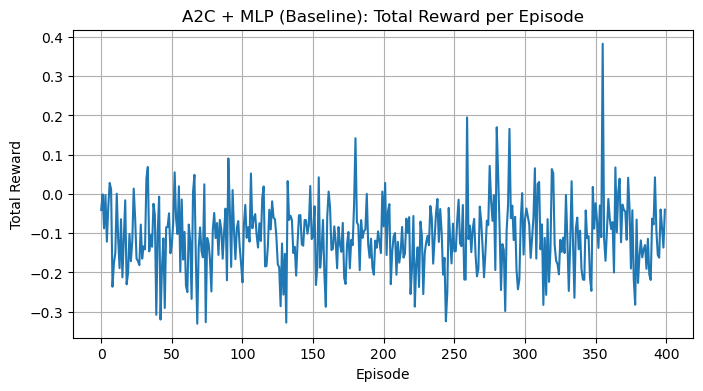

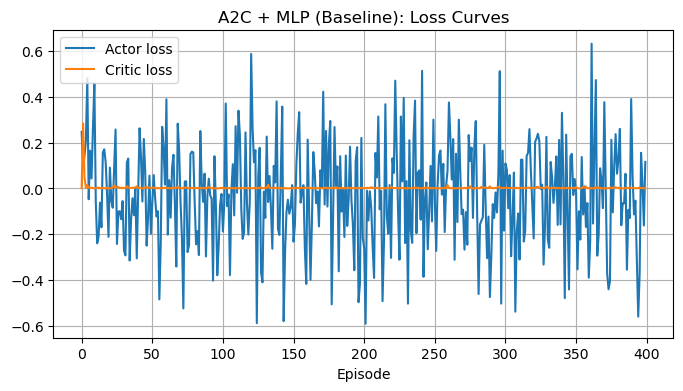

In [9]:
# ============================================
# STEP 5: Actor–Critic (A2C) with OHLC state
# ============================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# State is OHLC tensor: (WINDOW_SIZE, N_ASSETS, 4)
state_dim = WINDOW_SIZE * N_ASSETS * 4
action_dim = N_ASSETS
print("state_dim:", state_dim, "| action_dim:", action_dim)


class PolicyNet(nn.Module):
    """
    Actor network (MLP baseline):
    Input: flattened OHLC state (WINDOW_SIZE * N_ASSETS * 4)
    Output: mean vector (mu) for Gaussian over actions (size N_ASSETS)
    """

    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
        )
        # log_std as a learnable scalar (same std for all actions)
        self.log_std = nn.Parameter(torch.zeros(1))

    def forward(self, state_flat: torch.Tensor):
        """
        state_flat: tensor shape (batch, state_dim) or (state_dim,)
        returns: mu (batch, action_dim) or (action_dim,), log_std (scalar)
        """
        if state_flat.dim() == 1:
            state_flat = state_flat.unsqueeze(0)   # (1, state_dim)
        mu = self.net(state_flat)                 # (batch, action_dim)
        return mu, self.log_std


class ValueNet(nn.Module):
    """
    Critic network:
    Input: flattened OHLC state
    Output: scalar value V(s)
    """

    def __init__(self, state_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, state_flat: torch.Tensor):
        """
        state_flat: (batch, state_dim) or (state_dim,)
        returns: (batch, 1)
        """
        if state_flat.dim() == 1:
            state_flat = state_flat.unsqueeze(0)
        return self.net(state_flat)


actor = PolicyNet(state_dim, action_dim).to(device)
critic = ValueNet(state_dim).to(device)

actor_optimizer = optim.Adam(actor.parameters(), lr=3e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=3e-4)


GAMMA = 0.99
MAX_EPISODES = 400          
EPISODE_LENGTH = 252        # match env.episode_length
VALUE_COEF = 0.5            # weight for critic loss in total loss


def preprocess_state(state_np: np.ndarray) -> torch.Tensor:
    """
    Convert OHLC state (WINDOW_SIZE, N_ASSETS, 4) to a flattened
    normalized tensor on the right device.
    """
    # normalize window like the paper
    norm_state = normalize_ohlc_window(state_np)  # (T, N, 4)
    state_flat = norm_state.flatten().astype(np.float32)
    state_t = torch.from_numpy(state_flat).to(device)
    return state_t


def select_action(state_t: torch.Tensor):
    """
    Given a torch state tensor (state_dim,),
    returns:
      - action_np: numpy array (N_ASSETS,)
      - log_prob: torch scalar
    """
    mu, log_std = actor(state_t)           # mu: (1, N_ASSETS)
    mu = mu.squeeze(0)                     # (N_ASSETS,)
    std = log_std.exp()

    dist = torch.distributions.Normal(mu, std)
    action_t = dist.rsample()              # (N_ASSETS,)
    log_prob = dist.log_prob(action_t).sum()

    action_np = action_t.detach().cpu().numpy()
    return action_np, log_prob


def compute_returns(rewards, gamma=GAMMA):
    """Discounted returns G_t."""
    G = []
    R = 0.0
    for r in reversed(rewards):
        R = r + gamma * R
        G.append(R)
    G.reverse()
    return torch.tensor(G, dtype=torch.float32, device=device)


# ---------- A2C training loop ----------
env_a2c = PortfolioEnv(
    returns_arr=train_arr,
    ohlc_arr=train_ohlc_arr,
    dates=train_dates,
    window_size=WINDOW_SIZE,
    episode_length=EPISODE_LENGTH,
    transaction_cost=0.001,
)

episode_rewards = []
actor_losses = []
critic_losses = []

for episode in range(1, MAX_EPISODES + 1):
    state = env_a2c.reset(random_start=True)

    states_t = []
    log_probs = []
    rewards = []

    for t in range(EPISODE_LENGTH):
        state_t = preprocess_state(state)              # (state_dim,)
        action_np, log_prob = select_action(state_t)

        next_state, reward, done, info = env_a2c.step(action_np)

        states_t.append(state_t)                       # list of (state_dim,)
        log_probs.append(log_prob)                     # list of scalars
        rewards.append(reward)

        state = next_state
        if done:
            break

    # Stack states to a batch tensor: shape (T, state_dim)
    states_batch = torch.stack(states_t)               # (T, state_dim)

    # 1) Raw discounted returns
    returns_raw = compute_returns(rewards, GAMMA)      # (T,)

    # 2) Critic: V(s) ≈ returns
    values_t = critic(states_batch).squeeze(-1)        # (T,)
    critic_loss = F.mse_loss(values_t, returns_raw)

    # 3) Advantages
    advantages = returns_raw - values_t.detach()
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # 4) Actor loss (policy gradient)
    log_probs_t = torch.stack(log_probs)               # (T,)
    actor_loss = -(log_probs_t * advantages).mean()

    total_loss = actor_loss + VALUE_COEF * critic_loss

    actor_optimizer.zero_grad()
    critic_optimizer.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(actor.parameters(), max_norm=1.0)
    torch.nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.0)
    actor_optimizer.step()
    critic_optimizer.step()

    total_reward = float(sum(rewards))
    episode_rewards.append(total_reward)
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())

    if episode % 10 == 0:
        print(
            f"Episode {episode:4d} | "
            f"Steps: {len(rewards):3d} | "
            f"Total reward: {total_reward: .4f} | "
            f"Actor loss: {actor_loss.item(): .4f} | "
            f"Critic loss: {critic_loss.item(): .4f}"
        )

print("A2C Training finished.")

# ---------- A2C plots ----------
plt.figure(figsize=(8,4))
plt.plot(episode_rewards)
plt.title("A2C + MLP (Baseline): Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(actor_losses, label="Actor loss")
plt.plot(critic_losses, label="Critic loss")
plt.legend()
plt.title("A2C + MLP (Baseline): Loss Curves")
plt.xlabel("Episode")
plt.grid(True)
plt.show()


# 2.PPO +CNN

Using device: cpu
PPO state for CNN: C=4, H=30, W=24 | action_dim=24
Update   5 | Mean return: -0.0226 | Policy loss: -0.0061 | Value loss:  0.0005 | Entropy:  34.3529
Update  10 | Mean return: -0.0258 | Policy loss: -0.0067 | Value loss:  0.0007 | Entropy:  34.6560
Update  15 | Mean return: -0.0300 | Policy loss: -0.0103 | Value loss:  0.0007 | Entropy:  35.0784
Update  20 | Mean return: -0.0379 | Policy loss: -0.0030 | Value loss:  0.0007 | Entropy:  35.7611
Update  25 | Mean return: -0.0434 | Policy loss: -0.0039 | Value loss:  0.0005 | Entropy:  35.9789
Update  30 | Mean return: -0.0373 | Policy loss: -0.0038 | Value loss:  0.0008 | Entropy:  36.3490
Update  35 | Mean return: -0.0298 | Policy loss: -0.0011 | Value loss:  0.0005 | Entropy:  36.8274
Update  40 | Mean return: -0.0348 | Policy loss: -0.0071 | Value loss:  0.0005 | Entropy:  37.3552
Update  45 | Mean return: -0.0370 | Policy loss: -0.0056 | Value loss:  0.0011 | Entropy:  37.6664
Update  50 | Mean return: -0.0412 | Poli

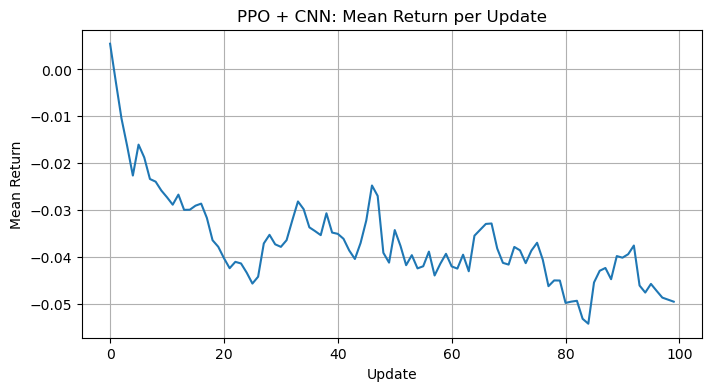

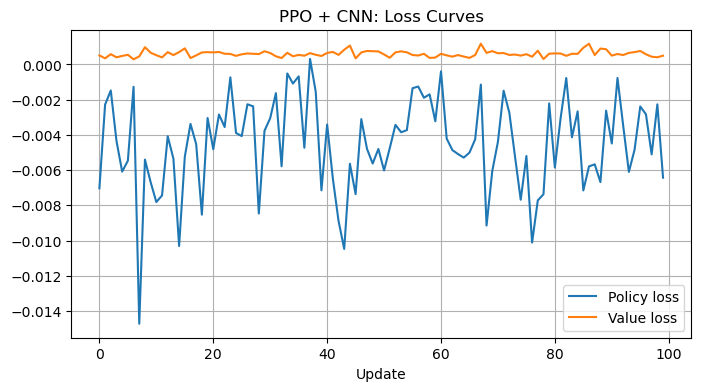

In [10]:
# ============================================
# STEP 5: PPO with CNN on OHLC state 
# ============================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# State: (WINDOW_SIZE, N_ASSETS, 4) → CNN expects (4, H, W)
state_channels = 4
state_h = WINDOW_SIZE
state_w = N_ASSETS
action_dim = N_ASSETS
print(f"PPO state for CNN: C={state_channels}, H={state_h}, W={state_w} | action_dim={action_dim}")


# -------------------------
# VGG-like CNN backbone 
# -------------------------
class CNNBackbone(nn.Module):
    """
    VGG-style backbone as in the paper:
    Conv2D 3x3 (pad=2) -> ReLU -> MaxPool2d(2)
    Conv2D 3x3 (pad=1) -> ReLU
    Conv2D 3x3 (pad=1) -> ReLU -> MaxPool2d(2)
    Conv2D 3x3 (pad=1) -> ReLU
    Conv2D 3x3 (pad=1) -> ReLU -> MaxPool2d(2)

    Channels (in,out) ≈ (4→64→64→128→128→256).
    """

    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # block 1
            nn.Conv2d(state_channels, 64, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),   # H,W: 60x24 -> 30x12-ish

            # block 2
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),   # ~30x12 -> 15x6

            # block 3
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),   # ~15x6 -> 7x3
        )

        # compute feature_dim dynamically to avoid shape mistakes
        with torch.no_grad():
            dummy = torch.zeros(1, state_channels, state_h, state_w)
            out = self.conv(dummy)
            self.feature_dim = out.view(1, -1).size(1)

    def forward(self, x):
        # x: (B, 4, 60, 24)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return x


class ActorCriticCNN(nn.Module):
    """
    Shared VGG-like CNN backbone with separate actor and critic heads.
    """

    def __init__(self, action_dim, hidden_dim=128, dropout_p=0.1):
        super().__init__()
        self.backbone = CNNBackbone()

        self.actor_head = nn.Sequential(
            nn.Linear(self.backbone.feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, action_dim),
        )

        self.critic_head = nn.Sequential(
            nn.Linear(self.backbone.feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, 1),
        )

        # global log_std for Gaussian policy
        self.log_std = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """
        x: (batch, 4, 60, 24) or (4, 60, 24)
        returns:
          mu: (batch, action_dim)
          value: (batch, 1)
          log_std: scalar param
        """
        if x.dim() == 3:
            x = x.unsqueeze(0)

        features = self.backbone(x)
        mu = self.actor_head(features)
        value = self.critic_head(features)
        return mu, value, self.log_std


policy_cnn = ActorCriticCNN(action_dim=action_dim).to(device)
optimizer_cnn = optim.Adam(policy_cnn.parameters(), lr=3e-4)


# -------------------------
# PPO hyperparameters
# -------------------------
GAMMA = 0.99
LAMBDA = 0.95
CLIP_EPS = 0.2
K_EPOCHS = 5
BATCH_SIZE = 128
MAX_UPDATES = 100
EPISODES_PER_UPDATE = 4
EPISODE_LENGTH = 252
ENTROPY_COEF = 0.01
VALUE_COEF = 0.5


# -------------------------
# Utilities
# -------------------------
def preprocess_state_cnn(state_np: np.ndarray) -> torch.Tensor:
    """
    Convert state (WINDOW_SIZE, N_ASSETS, 4) to tensor (4, H, W),
    with normalization similar to the paper.
    """
    norm_state = normalize_ohlc_window(state_np)   # (T, N, 4)
    # (T, N, 4) -> (4, T, N) = (C, H, W)
    state_chw = np.transpose(norm_state, (2, 0, 1)).astype(np.float32)
    state_t = torch.from_numpy(state_chw).to(device)
    return state_t


def compute_gae(rewards, values_ext, dones, gamma=GAMMA, lam=LAMBDA):
    """
    rewards: (T,)
    values_ext: (T+1,)  (values for each state plus bootstrap)
    dones: (T,)
    returns: (returns, advantages) both (T,)
    """
    T = rewards.size(0)
    advantages = torch.zeros(T, device=device)
    gae = 0.0

    for t in reversed(range(T)):
        mask = 1.0 - dones[t]
        delta = rewards[t] + gamma * values_ext[t + 1] * mask - values_ext[t]
        gae = delta + gamma * lam * mask * gae
        advantages[t] = gae

    returns = advantages + values_ext[:-1]
    return returns, advantages


def collect_trajectories(env, policy, episodes_per_update=EPISODES_PER_UPDATE):
    """
    Collect transitions from several episodes for PPO update.
    """
    all_states = []
    all_actions = []
    all_log_probs = []
    all_rewards = []
    all_dones = []
    all_values = []

    last_state = None

    for ep in range(episodes_per_update):
        state = env.reset(random_start=True)
        done = False
        steps = 0

        while not done and steps < EPISODE_LENGTH:
            state_t = preprocess_state_cnn(state)  # (4,60,24)

            with torch.no_grad():
                mu, value, log_std = policy(state_t.unsqueeze(0))
                mu = mu.squeeze(0)         # (action_dim,)
                value = value.squeeze(0)   # (1,) -> scalar
                std = log_std.exp()
                dist = Normal(mu, std)
                action_t = dist.rsample()  # (action_dim,)
                log_prob_t = dist.log_prob(action_t).sum()

            action_np = action_t.cpu().numpy()
            next_state, reward, done, info = env.step(action_np)

            all_states.append(state_t)
            all_actions.append(action_t)
            all_log_probs.append(log_prob_t)
            all_rewards.append(float(reward))
            all_dones.append(float(done))
            all_values.append(value.squeeze())

            state = next_state
            last_state = state
            steps += 1

    states = torch.stack(all_states).to(device)       # (N, 4,60,24)
    actions = torch.stack(all_actions).to(device)     # (N, action_dim)
    log_probs_old = torch.stack(all_log_probs).to(device)  # (N,)
    rewards = torch.tensor(all_rewards, dtype=torch.float32, device=device)  # (N,)
    dones = torch.tensor(all_dones, dtype=torch.float32, device=device)      # (N,)
    values = torch.stack(all_values).to(device)       # (N,)

    # one extra bootstrap value
    with torch.no_grad():
        last_state_t = preprocess_state_cnn(last_state)
        last_value = policy(last_state_t.unsqueeze(0))[1].squeeze(0).squeeze()
        values_ext = torch.cat([values, last_value.unsqueeze(0)], dim=0)  # (N+1,)

    returns, advantages = compute_gae(rewards, values_ext, dones, GAMMA, LAMBDA)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    return {
        "states": states,
        "actions": actions,
        "log_probs_old": log_probs_old,
        "returns": returns,
        "advantages": advantages,
    }


# -------------------------
# PPO + CNN training loop
# -------------------------
env_cnn = PortfolioEnv(
    returns_arr=train_arr,
    ohlc_arr=train_ohlc_arr,
    dates=train_dates,
    window_size=WINDOW_SIZE,
    episode_length=EPISODE_LENGTH,
    transaction_cost=0.001,
)

cnn_episode_rewards = []   # mean return per update
cnn_policy_losses = []
cnn_value_losses = []
cnn_entropy_history = []

for update in range(1, MAX_UPDATES + 1):
    traj = collect_trajectories(env_cnn, policy_cnn, EPISODES_PER_UPDATE)

    states = traj["states"]
    actions = traj["actions"]
    log_probs_old = traj["log_probs_old"]
    returns = traj["returns"]
    advantages = traj["advantages"]

    N = states.size(0)
    idx_all = torch.arange(N, device=device)

    mean_return = returns.mean().item()

    upd_pol_loss = 0.0
    upd_val_loss = 0.0
    upd_entropy = 0.0
    n_batches = 0

    for epoch in range(K_EPOCHS):
        perm = idx_all[torch.randperm(N)]
        for start in range(0, N, BATCH_SIZE):
            end = start + BATCH_SIZE
            batch_idx = perm[start:end]
            if batch_idx.numel() == 0:
                continue

            b_states = states[batch_idx]
            b_actions = actions[batch_idx]
            b_log_probs_old = log_probs_old[batch_idx]
            b_returns = returns[batch_idx]
            b_advantages = advantages[batch_idx]

            mu, values_pred, log_std = policy_cnn(b_states)
            values_pred = values_pred.squeeze(-1)
            std = log_std.exp()
            dist = Normal(mu, std)

            log_probs = dist.log_prob(b_actions).sum(dim=-1)
            entropy = dist.entropy().sum(dim=-1)

            ratios = torch.exp(log_probs - b_log_probs_old)

            surr1 = ratios * b_advantages
            surr2 = torch.clamp(ratios, 1.0 - CLIP_EPS, 1.0 + CLIP_EPS) * b_advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            value_loss = F.mse_loss(values_pred, b_returns)
            entropy_loss = -entropy.mean()

            loss = policy_loss + VALUE_COEF * value_loss + ENTROPY_COEF * entropy_loss

            optimizer_cnn.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_cnn.parameters(), max_norm=1.0)
            optimizer_cnn.step()

            upd_pol_loss += policy_loss.item()
            upd_val_loss += value_loss.item()
            upd_entropy += entropy.mean().item()
            n_batches += 1

    avg_pol = upd_pol_loss / n_batches
    avg_val = upd_val_loss / n_batches
    avg_ent = upd_entropy / n_batches

    cnn_episode_rewards.append(mean_return)
    cnn_policy_losses.append(avg_pol)
    cnn_value_losses.append(avg_val)
    cnn_entropy_history.append(avg_ent)

    if update % 5 == 0:
        print(
            f"Update {update:3d} | "
            f"Mean return: {mean_return: .4f} | "
            f"Policy loss: {avg_pol: .4f} | "
            f"Value loss: {avg_val: .4f} | "
            f"Entropy: {avg_ent: .4f}"
        )

print("PPO + CNN Training finished.")

# -------- PPO + CNN plots --------
plt.figure(figsize=(8,4))
plt.plot(cnn_episode_rewards)
plt.title("PPO + CNN: Mean Return per Update")
plt.xlabel("Update")
plt.ylabel("Mean Return")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(cnn_policy_losses, label="Policy loss")
plt.plot(cnn_value_losses, label="Value loss")
plt.legend()
plt.title("PPO + CNN: Loss Curves")
plt.xlabel("Update")
plt.grid(True)
plt.show()



# Transformer + PPO

In [11]:
# ============================================
# STEP 5: PPO with Transformer on OHLC state
# ============================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np

# We reuse `device`, `WINDOW_SIZE`, `N_ASSETS`, `PortfolioEnv`,
# `train_arr`, `train_ohlc_arr`, `train_dates`, GAMMA, LAMBDA, etc.

print("Using device:", device)

# ---------- State dimensions for Transformer ----------
# We treat each day as a token with (N_ASSETS * 4) features
trans_seq_len = WINDOW_SIZE           # 60
trans_embed_in = N_ASSETS * 4         # 24 * 4 = 96
trans_d_model = 128                   # embedding dimension for transformer
trans_nhead = 4
trans_num_layers = 2
trans_ff_dim = 256

print(
    f"PPO + Transformer state: seq_len={trans_seq_len}, "
    f"feature_dim={trans_embed_in} → d_model={trans_d_model}, action_dim={N_ASSETS}"
)


# ---------- Preprocess state for Transformer ----------
def preprocess_state_trans(state_np: np.ndarray) -> torch.Tensor:
    """
    Normalize OHLC window and reshape for Transformer encoder.
    Each day is a token with (N_ASSETS * 4) features.
    state_np: (WINDOW_SIZE, N_ASSETS, 4)
    returns: (WINDOW_SIZE, N_ASSETS*4) as torch tensor on device
    """
    norm_state = normalize_ohlc_window(state_np)      # (T, N, 4)
    T, N, C = norm_state.shape  # e.g., 60, 24, 4
    seq = norm_state.reshape(T, N * C).astype(np.float32)   # (T, N*C)
    return torch.from_numpy(seq).to(device)  # (T, D_in)


# ---------- Transformer backbone + Actor-Critic ----------
class TransformerBackbone(nn.Module):
    """
    Simple Transformer encoder backbone:
      - Input: (batch, T, D_in) = (batch, 60, N_ASSETS*4)
      - Linear projection to d_model
      - Add learnable positional embeddings
      - TransformerEncoder (2 layers, 4 heads)
      - Output: pooled feature vector (batch, d_model)
    """

    def __init__(
        self,
        d_in: int,
        d_model: int = trans_d_model,
        nhead: int = trans_nhead,
        num_layers: int = trans_num_layers,
        dim_feedforward: int = trans_ff_dim,
        dropout: float = 0.1,
        max_len: int = trans_seq_len,
    ):
        super().__init__()
        self.d_model = d_model

        # Project input features to d_model
        self.input_proj = nn.Linear(d_in, d_model)

        # Learnable positional embeddings: (1, T, d_model)
        self.pos_embedding = nn.Parameter(torch.zeros(1, max_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,   # input as (batch, seq, d_model)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Feature dimension after pooling is d_model
        self.feature_dim = d_model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (batch, T, D_in)
        returns: (batch, d_model)
        """
        # x_proj: (batch, T, d_model)
        x_proj = self.input_proj(x)

        # Add positional embeddings (truncate to seq length)
        T = x_proj.size(1)
        pos = self.pos_embedding[:, :T, :]   # (1, T, d_model)
        x_proj = x_proj + pos

        # Transformer encoder
        out = self.encoder(x_proj)  # (batch, T, d_model)

        # Simple pooling: mean over time
        features = out.mean(dim=1)  # (batch, d_model)
        return features


class ActorCriticTransformer(nn.Module):
    """
    Actor-Critic with Transformer backbone and Gaussian policy for continuous actions.
    """

    def __init__(self, action_dim: int, hidden_dim: int = 128, dropout_p: float = 0.1):
        super().__init__()
        self.backbone = TransformerBackbone(
            d_in=trans_embed_in,
            d_model=trans_d_model,
            nhead=trans_nhead,
            num_layers=trans_num_layers,
            dim_feedforward=trans_ff_dim,
            dropout=dropout_p,
            max_len=trans_seq_len,
        )

        self.actor_head = nn.Sequential(
            nn.Linear(self.backbone.feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, action_dim),
        )

        self.critic_head = nn.Sequential(
            nn.Linear(self.backbone.feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, 1),
        )

        # global log_std for Gaussian policy over actions
        self.log_std = nn.Parameter(torch.zeros(1))

    def forward(self, x: torch.Tensor):
        """
        x: (batch, T, D_in) or (T, D_in)
        returns:
          mu: (batch, action_dim)
          value: (batch, 1)
          log_std: scalar
        """
        if x.dim() == 2:
            x = x.unsqueeze(0)   # (1, T, D_in)

        features = self.backbone(x)  # (batch, d_model)
        mu = self.actor_head(features)       # (batch, action_dim)
        value = self.critic_head(features)   # (batch, 1)
        return mu, value, self.log_std


# Instantiate policy + optimizer
trans_policy = ActorCriticTransformer(action_dim=N_ASSETS).to(device)
trans_optimizer = optim.Adam(trans_policy.parameters(), lr=3e-4)


# ---------- GAE helper (reused from PPO) ----------
def compute_gae(rewards, values, dones, gamma=GAMMA, lam=LAMBDA):
    """
    Compute GAE advantages and returns for a single long trajectory.
    rewards: (T,)
    values:  (T+1,)
    dones:   (T,)
    Returns:
      advantages: (T,)
      returns:    (T,)
    """
    T = len(rewards)
    advantages = torch.zeros(T, dtype=torch.float32, device=device)
    gae = 0.0

    for t in reversed(range(T)):
        mask = 1.0 - dones[t]
        delta = rewards[t] + gamma * values[t + 1] * mask - values[t]
        gae = delta + gamma * lam * mask * gae
        advantages[t] = gae

    returns = advantages + values[:-1]
    return advantages, returns


# ---------- Collect trajectories for PPO + Transformer ----------
def collect_trajectories_trans(env, policy, episodes_per_update=4):
    """
    Collect transitions from multiple episodes for PPO with Transformer.
    Returns a dict of tensors for states, actions, old log_probs, returns, advantages.
    """
    all_states = []
    all_actions = []
    all_log_probs = []
    all_rewards = []
    all_dones = []
    all_values = []

    last_state = None

    for ep in range(episodes_per_update):
        state = env.reset(random_start=True)
        done = False
        step = 0

        while not done and step < EPISODE_LENGTH:
            state_t = preprocess_state_trans(state)  # (T, D_in)

            with torch.no_grad():
                mu, value, log_std = trans_policy(state_t.unsqueeze(0))  # batch=1
                mu = mu.squeeze(0)       # (action_dim,)
                value = value.squeeze(0) # (1,) -> scalar
                std = log_std.exp()
                dist = Normal(mu, std)
                action_t = dist.rsample()
                log_prob_t = dist.log_prob(action_t).sum()

            action_np = action_t.cpu().numpy()
            next_state, reward, done, info = env.step(action_np)

            all_states.append(state_t)            # (T, D_in)
            all_actions.append(action_t)          # (action_dim,)
            all_log_probs.append(log_prob_t)      # scalar
            all_rewards.append(reward)            # scalar
            all_dones.append(float(done))         # scalar
            all_values.append(value.squeeze())    # scalar

            state = next_state
            last_state = state
            step += 1

    # Convert lists to tensors
    states = torch.stack(all_states)                         # (N, T, D_in)
    actions = torch.stack(all_actions)                       # (N, action_dim)
    log_probs_old = torch.stack(all_log_probs)               # (N,)
    rewards = torch.tensor(all_rewards, dtype=torch.float32, device=device)  # (N,)
    dones = torch.tensor(all_dones, dtype=torch.float32, device=device)      # (N,)
    values = torch.stack(all_values)                         # (N,)

    # Bootstrap value for final state
    with torch.no_grad():
        last_state_t = preprocess_state_trans(last_state)
        last_value = trans_policy(last_state_t.unsqueeze(0))[1].squeeze(0).squeeze()
        values_ext = torch.cat([values, last_value.unsqueeze(0)], dim=0)  # (N+1,)

    advantages, returns = compute_gae(rewards, values_ext, dones, GAMMA, LAMBDA)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    return {
        "states": states,
        "actions": actions,
        "log_probs_old": log_probs_old,
        "returns": returns,
        "advantages": advantages,
    }


# ---------- PPO Hyperparameters (can mirror CNN) ----------
TRANS_GAMMA = GAMMA
TRANS_LAMBDA = LAMBDA
TRANS_CLIP_EPS = 0.2
TRANS_K_EPOCHS = 10
TRANS_BATCH_SIZE = 1024
TRANS_MAX_UPDATES = 50
TRANS_EPISODES_PER_UPDATE = 4
TRANS_ENTROPY_COEF = 0.01
TRANS_VALUE_COEF = 0.5

# ---------- PPO Training Loop (Transformer) ----------
env_trans = PortfolioEnv(
    returns_arr=train_arr,
    ohlc_arr=train_ohlc_arr,
    dates=train_dates,
    window_size=WINDOW_SIZE,
    episode_length=EPISODE_LENGTH,
    transaction_cost=0.001,
)

trans_episode_rewards = []   # approximate mean return per update
trans_policy_losses = []     # avg policy loss per update
trans_value_losses = []      # avg value loss per update
trans_entropy_history = []   # avg entropy per update

for update in range(1, TRANS_MAX_UPDATES + 1):
    traj = collect_trajectories_trans(env_trans, trans_policy, TRANS_EPISODES_PER_UPDATE)

    states = traj["states"]            # (N, T, D_in)
    actions = traj["actions"]          # (N, action_dim)
    log_probs_old = traj["log_probs_old"]
    returns = traj["returns"]
    advantages = traj["advantages"]

    N = states.size(0)
    indices = torch.arange(N, device=device)

    mean_return = returns.mean().item()

    upd_pol_loss = 0.0
    upd_val_loss = 0.0
    upd_entropy = 0.0
    n_batches = 0

    for epoch in range(TRANS_K_EPOCHS):
        perm = indices[torch.randperm(N)]
        for start in range(0, N, TRANS_BATCH_SIZE):
            end = start + TRANS_BATCH_SIZE
            batch_idx = perm[start:end]
            if batch_idx.numel() == 0:
                continue

            batch_states = states[batch_idx]      # (B, T, D_in)
            batch_actions = actions[batch_idx]    # (B, action_dim)
            batch_log_probs_old = log_probs_old[batch_idx]
            batch_returns = returns[batch_idx]
            batch_advantages = advantages[batch_idx]

            mu, values_pred, log_std = trans_policy(batch_states)
            values_pred = values_pred.squeeze(-1)   # (B,)
            std = log_std.exp()
            dist = Normal(mu, std)

            log_probs = dist.log_prob(batch_actions).sum(dim=-1)  # (B,)
            entropy = dist.entropy().sum(dim=-1)                  # (B,)

            ratios = torch.exp(log_probs - batch_log_probs_old)

            surr1 = ratios * batch_advantages
            surr2 = torch.clamp(ratios, 1.0 - TRANS_CLIP_EPS,
                                       1.0 + TRANS_CLIP_EPS) * batch_advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            value_loss = F.mse_loss(values_pred, batch_returns)
            entropy_loss = -entropy.mean()

            loss = (
                policy_loss
                + TRANS_VALUE_COEF * value_loss
                + TRANS_ENTROPY_COEF * entropy_loss
            )

            trans_optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(trans_policy.parameters(), max_norm=1.0)
            trans_optimizer.step()

            upd_pol_loss += policy_loss.item()
            upd_val_loss += value_loss.item()
            upd_entropy += entropy.mean().item()
            n_batches += 1

    if n_batches > 0:
        avg_pol = upd_pol_loss / n_batches
        avg_val = upd_val_loss / n_batches
        avg_ent = upd_entropy / n_batches
    else:
        avg_pol = avg_val = avg_ent = float("nan")

    trans_episode_rewards.append(mean_return)
    trans_policy_losses.append(avg_pol)
    trans_value_losses.append(avg_val)
    trans_entropy_history.append(avg_ent)

    if update % 5 == 0:
        print(
            f"[Transformer PPO] Update {update:3d} | "
            f"Mean return: {mean_return: .4f} | "
            f"Policy loss: {avg_pol: .4f} | "
            f"Value loss: {avg_val: .4f} | "
            f"Entropy: {avg_ent: .4f}"
        )

print("PPO + Transformer Training finished.")


Using device: cpu
PPO + Transformer state: seq_len=30, feature_dim=96 → d_model=128, action_dim=24
[Transformer PPO] Update   5 | Mean return:  0.0249 | Policy loss:  0.0034 | Value loss:  0.0007 | Entropy:  34.2585
[Transformer PPO] Update  10 | Mean return: -0.0100 | Policy loss: -0.0012 | Value loss:  0.0010 | Entropy:  34.4339
[Transformer PPO] Update  15 | Mean return: -0.0260 | Policy loss: -0.0006 | Value loss:  0.0009 | Entropy:  34.8592
[Transformer PPO] Update  20 | Mean return: -0.0256 | Policy loss:  0.0027 | Value loss:  0.0006 | Entropy:  34.9841
[Transformer PPO] Update  25 | Mean return: -0.0296 | Policy loss:  0.0058 | Value loss:  0.0005 | Entropy:  35.0739
[Transformer PPO] Update  30 | Mean return: -0.0315 | Policy loss:  0.0019 | Value loss:  0.0007 | Entropy:  35.3795
[Transformer PPO] Update  35 | Mean return: -0.0274 | Policy loss:  0.0069 | Value loss:  0.0010 | Entropy:  35.8229
[Transformer PPO] Update  40 | Mean return: -0.0418 | Policy loss: -0.0014 | Value

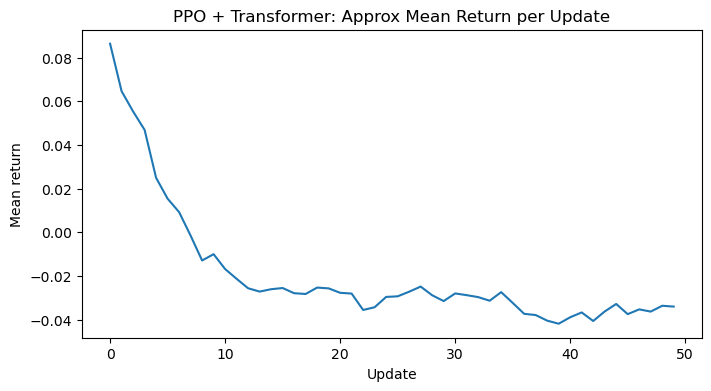

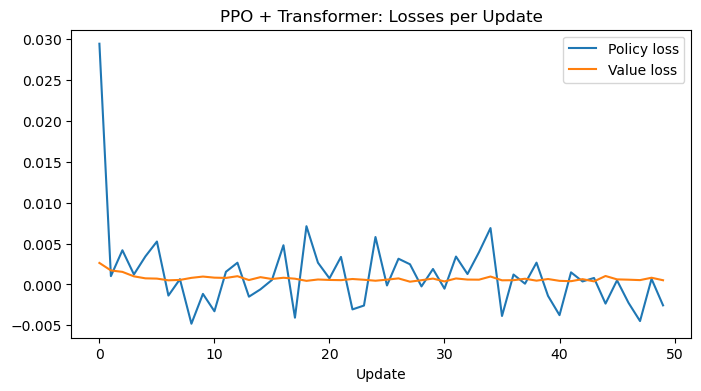

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(trans_episode_rewards)
plt.title("PPO + Transformer: Approx Mean Return per Update")
plt.xlabel("Update")
plt.ylabel("Mean return")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(trans_policy_losses, label="Policy loss")
plt.plot(trans_value_losses, label="Value loss")
plt.legend()
plt.title("PPO + Transformer: Losses per Update")
plt.xlabel("Update")
plt.show()

In [13]:
import numpy as np
import pandas as pd

# ---------- Helper: run one deterministic episode for a given policy ----------
def run_policy_episode(env, act_fn, random_start=False):
    """
    Run one full episode in env using act_fn(state) -> action_np.

    Returns:
        rewards: list of rewards
        pv_path: np.array of portfolio value path starting at 1.0
    """
    state = env.reset(random_start=random_start)
    rewards = []
    done = False

    while not done:
        # Get action from policy
        action_np = act_fn(state)

        # 🔧 Ensure shape is (n_assets,)
        action_np = np.asarray(action_np, dtype=float).reshape(-1)
        if action_np.shape[0] != env.n_assets:
            raise ValueError(
                f"act_fn returned action of shape {action_np.shape}, "
                f"expected length {env.n_assets}"
            )

        # Step environment
        next_state, reward, done, info = env.step(action_np)
        rewards.append(float(reward))
        state = next_state

    rewards = np.array(rewards, dtype=float)
    # reconstruct PV path from rewards (= log-returns)
    pv = np.exp(rewards.cumsum())
    return rewards, pv


# ---------- Simple performance metrics from a reward (log-return) series ----------
def perf_from_rewards(rewards, trading_days=252):
    """
    rewards: array-like of log returns
    """
    rewards = np.asarray(rewards, dtype=float)
    if rewards.size == 0:
        return {
            "mu": np.nan,
            "sigma": np.nan,
            "ann_mu": np.nan,
            "ann_sigma": np.nan,
            "sharpe": np.nan,
            "max_dd": np.nan,
        }

    mu = rewards.mean()
    sigma = rewards.std(ddof=1) if rewards.size > 1 else 0.0

    ann_mu = mu * trading_days
    ann_sigma = sigma * np.sqrt(trading_days) if sigma > 0 else 0.0
    sharpe = ann_mu / ann_sigma if ann_sigma > 0 else np.nan

    # max drawdown on PV path
    pv = np.exp(rewards.cumsum())
    running_max = np.maximum.accumulate(pv)
    dd = pv / running_max - 1.0
    max_dd = dd.min()

    return {
        "mu": mu,
        "sigma": sigma,
        "ann_mu": ann_mu,
        "ann_sigma": ann_sigma,
        "sharpe": sharpe,
        "max_dd": max_dd,
    }


# ---------- Equal-weight benchmark with same horizon as RL policies ----------
def equal_weight_perf(returns_arr, start_idx, length, trading_days=252):
    """
    Equal-weight benchmark over EXACTLY the same horizon as the RL episode.

    returns_arr : (T, N_ASSETS) log returns
    start_idx   : index in [0, T) where the episode starts (for rewards)
    length      : number of steps in the episode (episode_length)

    We use:
      ew_log_ret[t] = w' * r[start_idx + t]
    """
    T, N = returns_arr.shape
    w = np.ones(N) / N

    end_idx = min(start_idx + length, T)
    # slice the same horizon the RL env sees
    port_log_ret = returns_arr[start_idx:end_idx] @ w  # shape (L,)

    metrics = perf_from_rewards(port_log_ret, trading_days=trading_days)
    pv_path = np.exp(port_log_ret.cumsum())

    metrics["pv"] = pv_path              # PV over that horizon
    metrics["log_returns"] = port_log_ret
    return metrics


# ---------- Action wrappers for each trained policy ----------
def act_a2c(state_np):
    state_t = preprocess_state(state_np)          # (state_dim,)
    with torch.no_grad():
        mu, log_std = actor(state_t)
        std = log_std.exp()
        dist = torch.distributions.Normal(mu, std)
        action_t = dist.mean   # use mean at eval
    return action_t.cpu().numpy()

def act_cnn(state_np):
    state_t = preprocess_state_cnn(state_np)      # (4, H, W)
    with torch.no_grad():
        mu, value, log_std = policy_cnn(state_t.unsqueeze(0))
        std = log_std.exp()
        dist = Normal(mu, std)
        action_t = dist.mean.squeeze(0)
    return action_t.cpu().numpy()

def act_trans(state_np):
    state_t = preprocess_state_trans(state_np)    # (T, D_in)
    with torch.no_grad():
        mu, value, log_std = trans_policy(state_t.unsqueeze(0))
        std = log_std.exp()
        dist = Normal(mu, std)
        action_t = dist.mean.squeeze(0)
    return action_t.cpu().numpy()


# ---------- evaluate a given split ----------
def evaluate_split(split_name, returns_arr, ohlc_arr, dates_index):
    """
    Evaluate A2C, PPO+CNN, PPO+Transformer, and EQW on ONE split
    (train/val/test), using the same PortfolioEnv setup.
    """
    print(f"\n===== Evaluation on {split_name} set =====")

    T_split = returns_arr.shape[0]
    # Make sure we have enough data for both window and at least 1 step
    effective_horizon = T_split - WINDOW_SIZE - 1
    if effective_horizon <= 0:
        raise ValueError(
            f"{split_name}: not enough data (T={T_split}) for WINDOW_SIZE={WINDOW_SIZE}"
        )

    ep_len = effective_horizon

    def make_env_for_split():
        return PortfolioEnv(
            returns_arr=returns_arr,
            ohlc_arr=ohlc_arr,
            dates=dates_index,
            window_size=WINDOW_SIZE,
            episode_length=ep_len,
            transaction_cost=0.001,
        )

    # 1) A2C + MLP
    env_split = make_env_for_split()
    a2c_rewards, a2c_pv = run_policy_episode(env_split, act_a2c, random_start=False)
    a2c_perf = perf_from_rewards(a2c_rewards)
    print(f"A2C + MLP   | "
          f"Ann. return: {a2c_perf['ann_mu']:.3f} | "
          f"Ann. vol: {a2c_perf['ann_sigma']:.3f} | "
          f"Sharpe: {a2c_perf['sharpe']:.3f} | "
          f"MaxDD: {a2c_perf['max_dd']:.3f}")

    # 2) PPO + CNN
    env_split = make_env_for_split()
    cnn_rewards, cnn_pv = run_policy_episode(env_split, act_cnn, random_start=False)
    cnn_perf = perf_from_rewards(cnn_rewards)
    print(f"PPO + CNN   | "
          f"Ann. return: {cnn_perf['ann_mu']:.3f} | "
          f"Ann. vol: {cnn_perf['ann_sigma']:.3f} | "
          f"Sharpe: {cnn_perf['sharpe']:.3f} | "
          f"MaxDD: {cnn_perf['max_dd']:.3f}")

    # 3) PPO + Transformer
    env_split = make_env_for_split()
    trans_rewards, trans_pv = run_policy_episode(env_split, act_trans, random_start=False)
    trans_perf = perf_from_rewards(trans_rewards)
    print(f"PPO + Trans | "
          f"Ann. return: {trans_perf['ann_mu']:.3f} | "
          f"Ann. vol: {trans_perf['ann_sigma']:.3f} | "
          f"Sharpe: {trans_perf['sharpe']:.3f} | "
          f"MaxDD: {trans_perf['max_dd']:.3f}")

    # 4) Equal-weight benchmark, SAME horizon as RL episode
    # RL env reset(random_start=False) starts at current_t = WINDOW_SIZE - 1
    # First reward uses returns_arr[WINDOW_SIZE], then WINDOW_SIZE+1, ...
    start_idx = WINDOW_SIZE
    ew_perf = equal_weight_perf(
        returns_arr,
        start_idx=start_idx,
        length=ep_len,
        trading_days=252,
    )

    print(f"Equal-weight | "
          f"Ann. return: {ew_perf['ann_mu']:.3f} | "
          f"Ann. vol: {ew_perf['ann_sigma']:.3f} | "
          f"Sharpe: {ew_perf['sharpe']:.3f} | "
          f"MaxDD: {ew_perf['max_dd']:.3f}")

    return {
        "A2C": {
            **a2c_perf,
            "pv": a2c_pv,
            "log_returns": a2c_rewards,
        },
        "PPO_CNN": {
            **cnn_perf,
            "pv": cnn_pv,
            "log_returns": cnn_rewards,
        },
        "PPO_TRANS": {
            **trans_perf,
            "pv": trans_pv,
            "log_returns": trans_rewards,
        },
        "EW": ew_perf,
    }


# ---------- Run evaluation on VAL and TEST ----------
val_results = evaluate_split("Validation", val_arr, val_ohlc_arr, val_dates)
test_results = evaluate_split("Test",       test_arr, test_ohlc_arr, test_dates)



===== Evaluation on Validation set =====
A2C + MLP   | Ann. return: 0.085 | Ann. vol: 0.229 | Sharpe: 0.371 | MaxDD: -0.380
PPO + CNN   | Ann. return: 0.082 | Ann. vol: 0.229 | Sharpe: 0.356 | MaxDD: -0.377
PPO + Trans | Ann. return: 0.090 | Ann. vol: 0.230 | Sharpe: 0.392 | MaxDD: -0.376
Equal-weight | Ann. return: 0.091 | Ann. vol: 0.229 | Sharpe: 0.397 | MaxDD: -0.375

===== Evaluation on Test set =====
A2C + MLP   | Ann. return: 0.115 | Ann. vol: 0.136 | Sharpe: 0.841 | MaxDD: -0.150
PPO + CNN   | Ann. return: 0.116 | Ann. vol: 0.136 | Sharpe: 0.851 | MaxDD: -0.152
PPO + Trans | Ann. return: 0.118 | Ann. vol: 0.137 | Sharpe: 0.864 | MaxDD: -0.151
Equal-weight | Ann. return: 0.122 | Ann. vol: 0.136 | Sharpe: 0.892 | MaxDD: -0.149


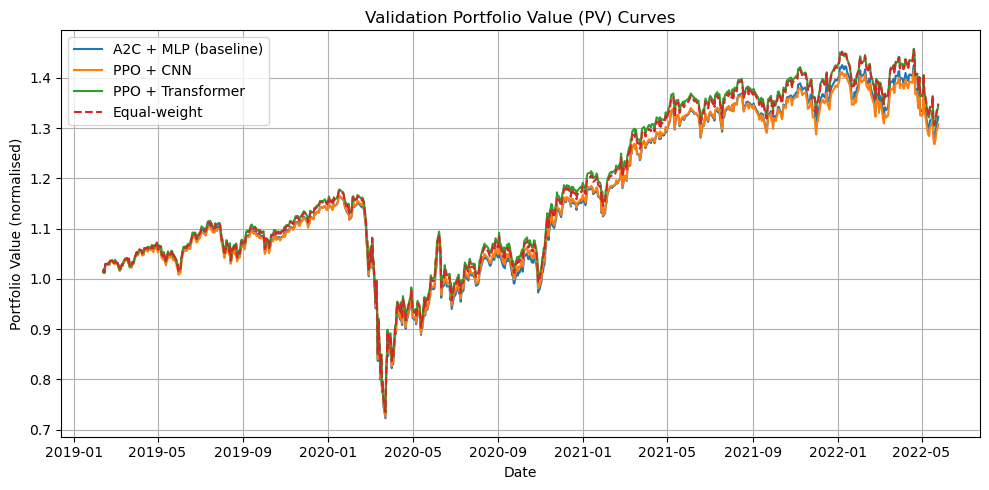

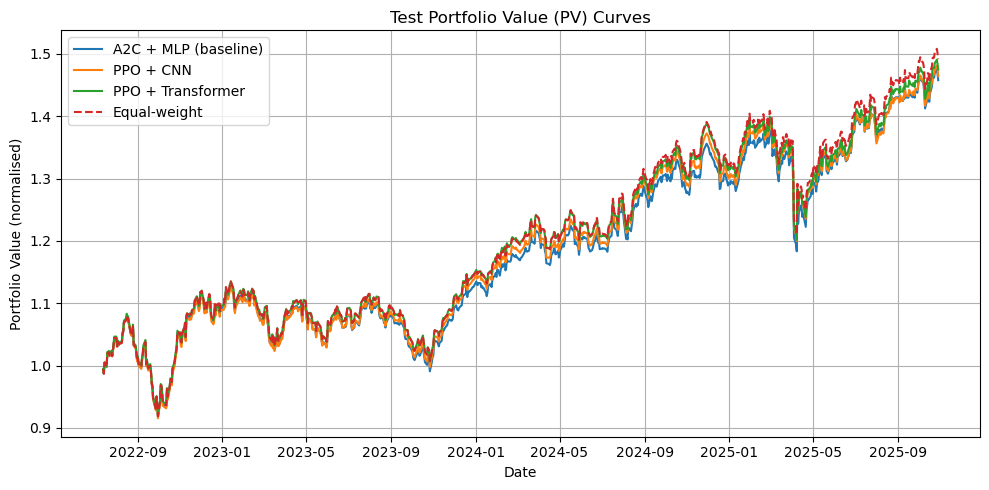

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pv_curves(split_name, results, dates_index):
    """
    Plot PV curves for A2C, PPO+CNN, PPO+Transformer, and Equal-weight
    on a given split (val/test).

    All PV paths are assumed to have the SAME length (ep_len),
    and they all correspond to rewards starting from index = WINDOW_SIZE.
    """
    # choose one PV to get horizon length (A2C or EW)
    pv_ref = results["A2C"]["pv"]
    pv_ref = np.asarray(pv_ref, dtype=float)
    ep_len = len(pv_ref)

    # aligned dates slice: dates[WINDOW_SIZE : WINDOW_SIZE + ep_len]
    start = WINDOW_SIZE
    end = start + ep_len
    dates = dates_index[start:end]

    plt.figure(figsize=(10, 5))

    # 1) A2C
    plt.plot(dates, results["A2C"]["pv"], label="A2C + MLP (baseline)")

    # 2) PPO + CNN
    plt.plot(dates, results["PPO_CNN"]["pv"], label="PPO + CNN")

    # 3) PPO + Transformer
    plt.plot(dates, results["PPO_TRANS"]["pv"], label="PPO + Transformer")

    # 4) Equal-weight
    plt.plot(dates, results["EW"]["pv"], label="Equal-weight", linestyle="--")

    plt.title(f"{split_name} Portfolio Value (PV) Curves")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (normalised)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_pv_curves("Validation", val_results, val_dates)
plot_pv_curves("Test",       test_results, test_dates)